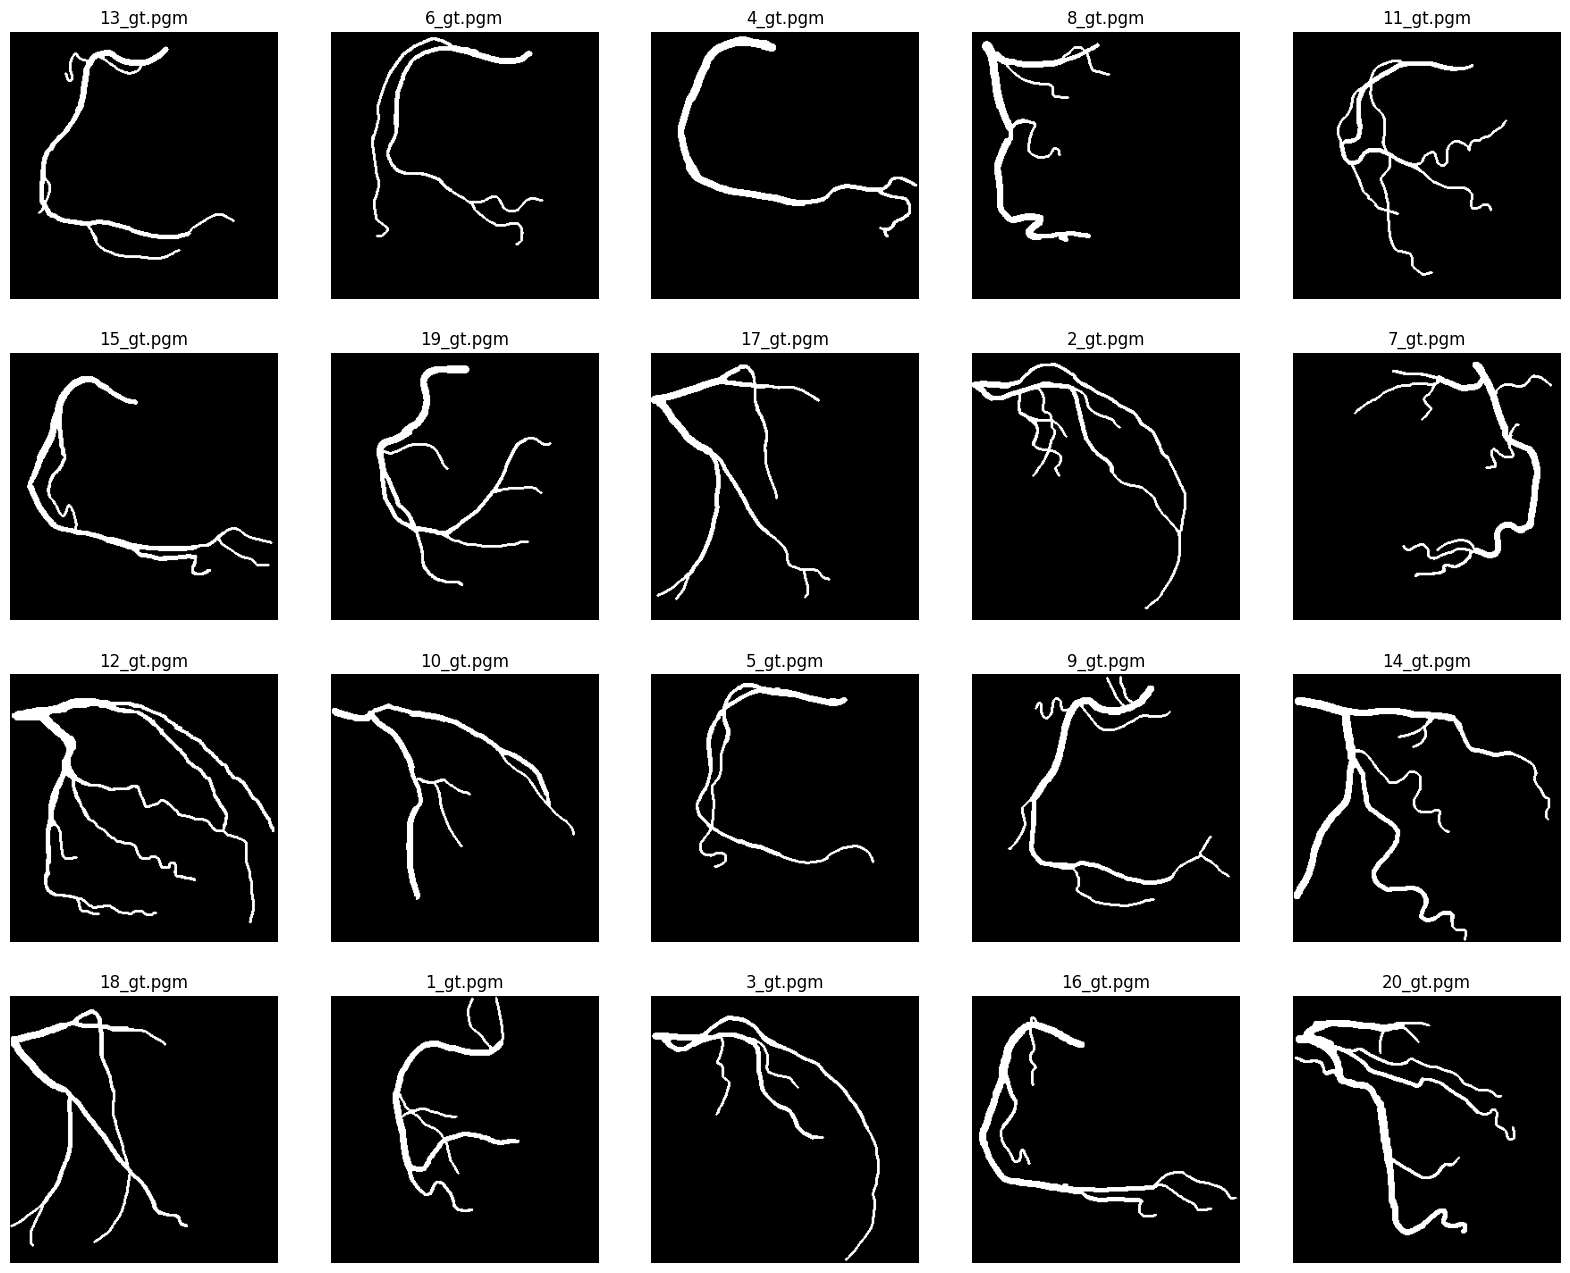

In [161]:
from skimage import io
import matplotlib.pyplot as plt
import os

carpeta_imagenes = './database'  # Asegúrate de cambiar esto por tu ruta correcta
archivos = [archivo for archivo in os.listdir(carpeta_imagenes) if archivo.endswith('_gt.pgm')]
imagenes = []

for archivo in archivos:
    image_path = os.path.join(carpeta_imagenes, archivo)
    imagen = io.imread(image_path)
    imagenes.append(imagen)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))
for ax, imagen, nombre in zip(axes.flat, imagenes, archivos):
    ax.imshow(imagen, cmap='gray')
    ax.set_title(nombre)
    ax.axis('off')


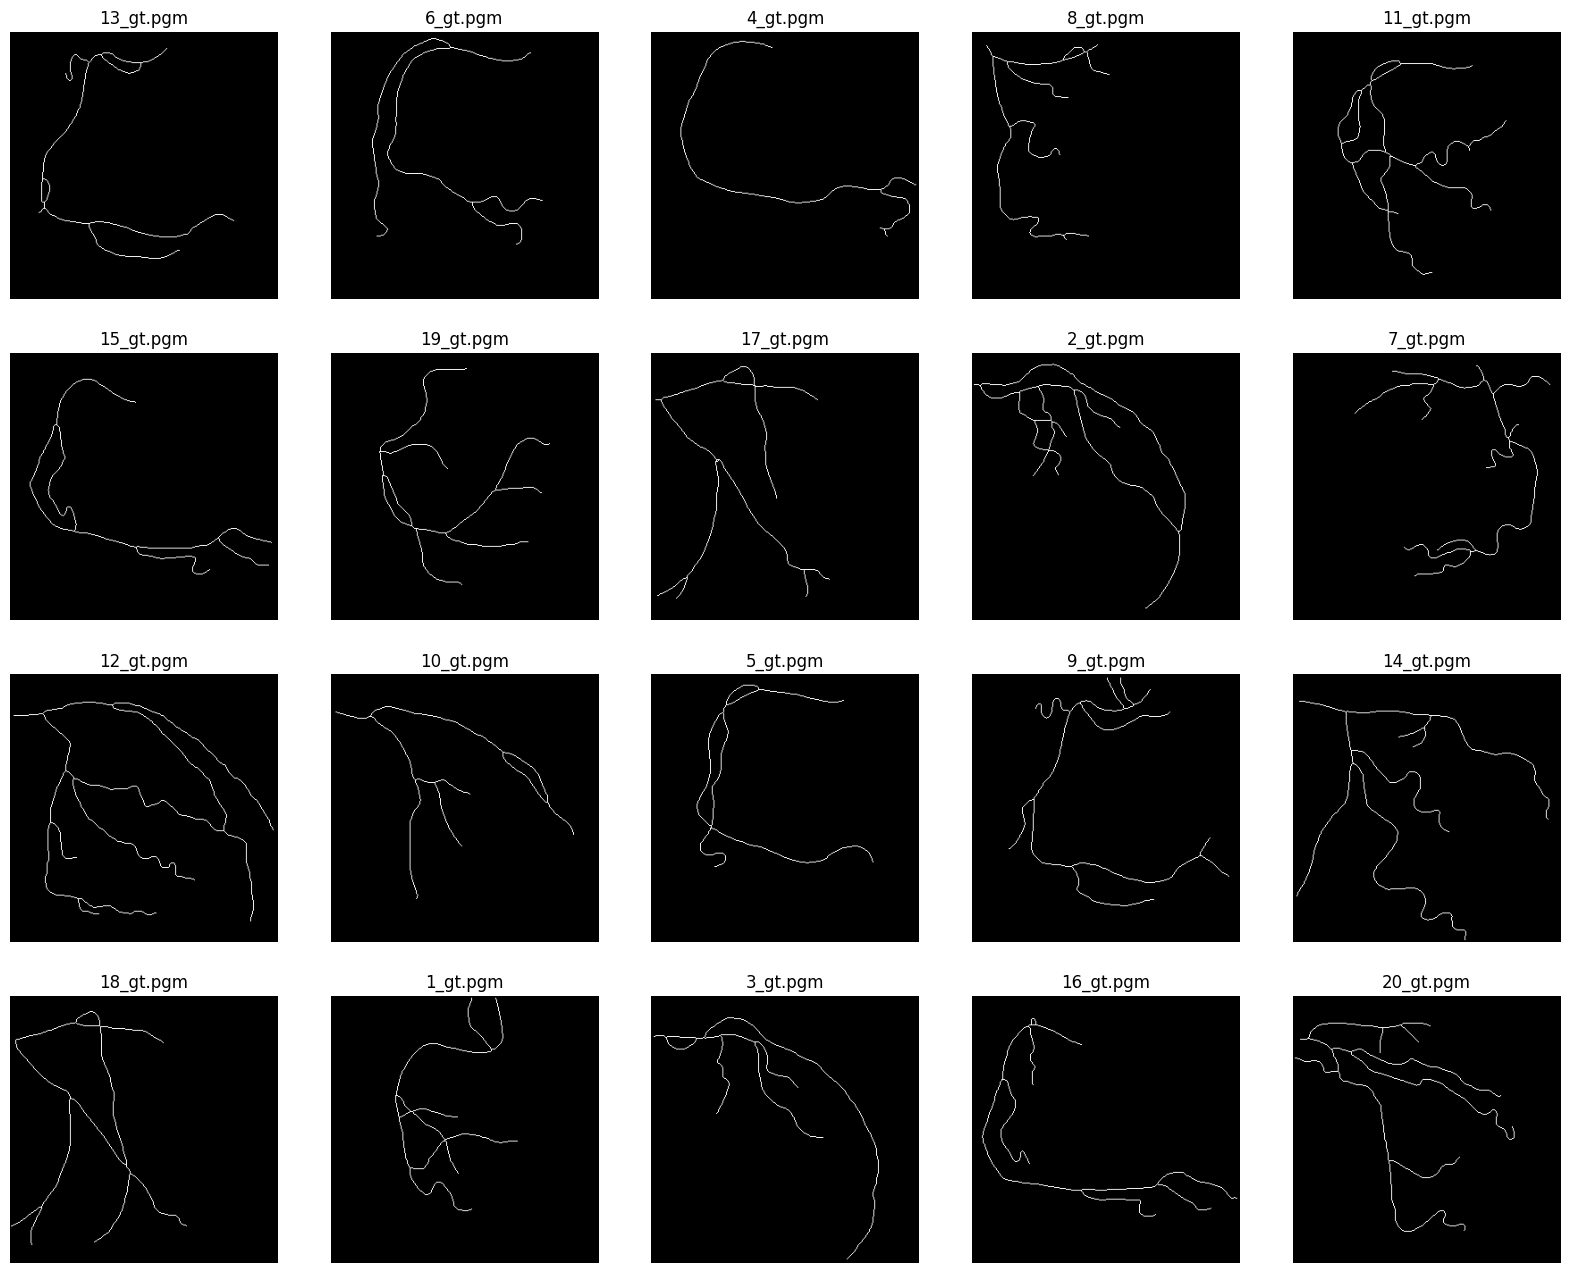

In [162]:
from skimage.morphology import skeletonize

esqueletos = [skeletonize(imagen > 0) for imagen in imagenes]

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))
for ax, esqueleto, nombre in zip(axes.flat, esqueletos, archivos):
    ax.imshow(esqueleto, cmap='gray')
    ax.set_title(nombre)
    ax.axis('off')

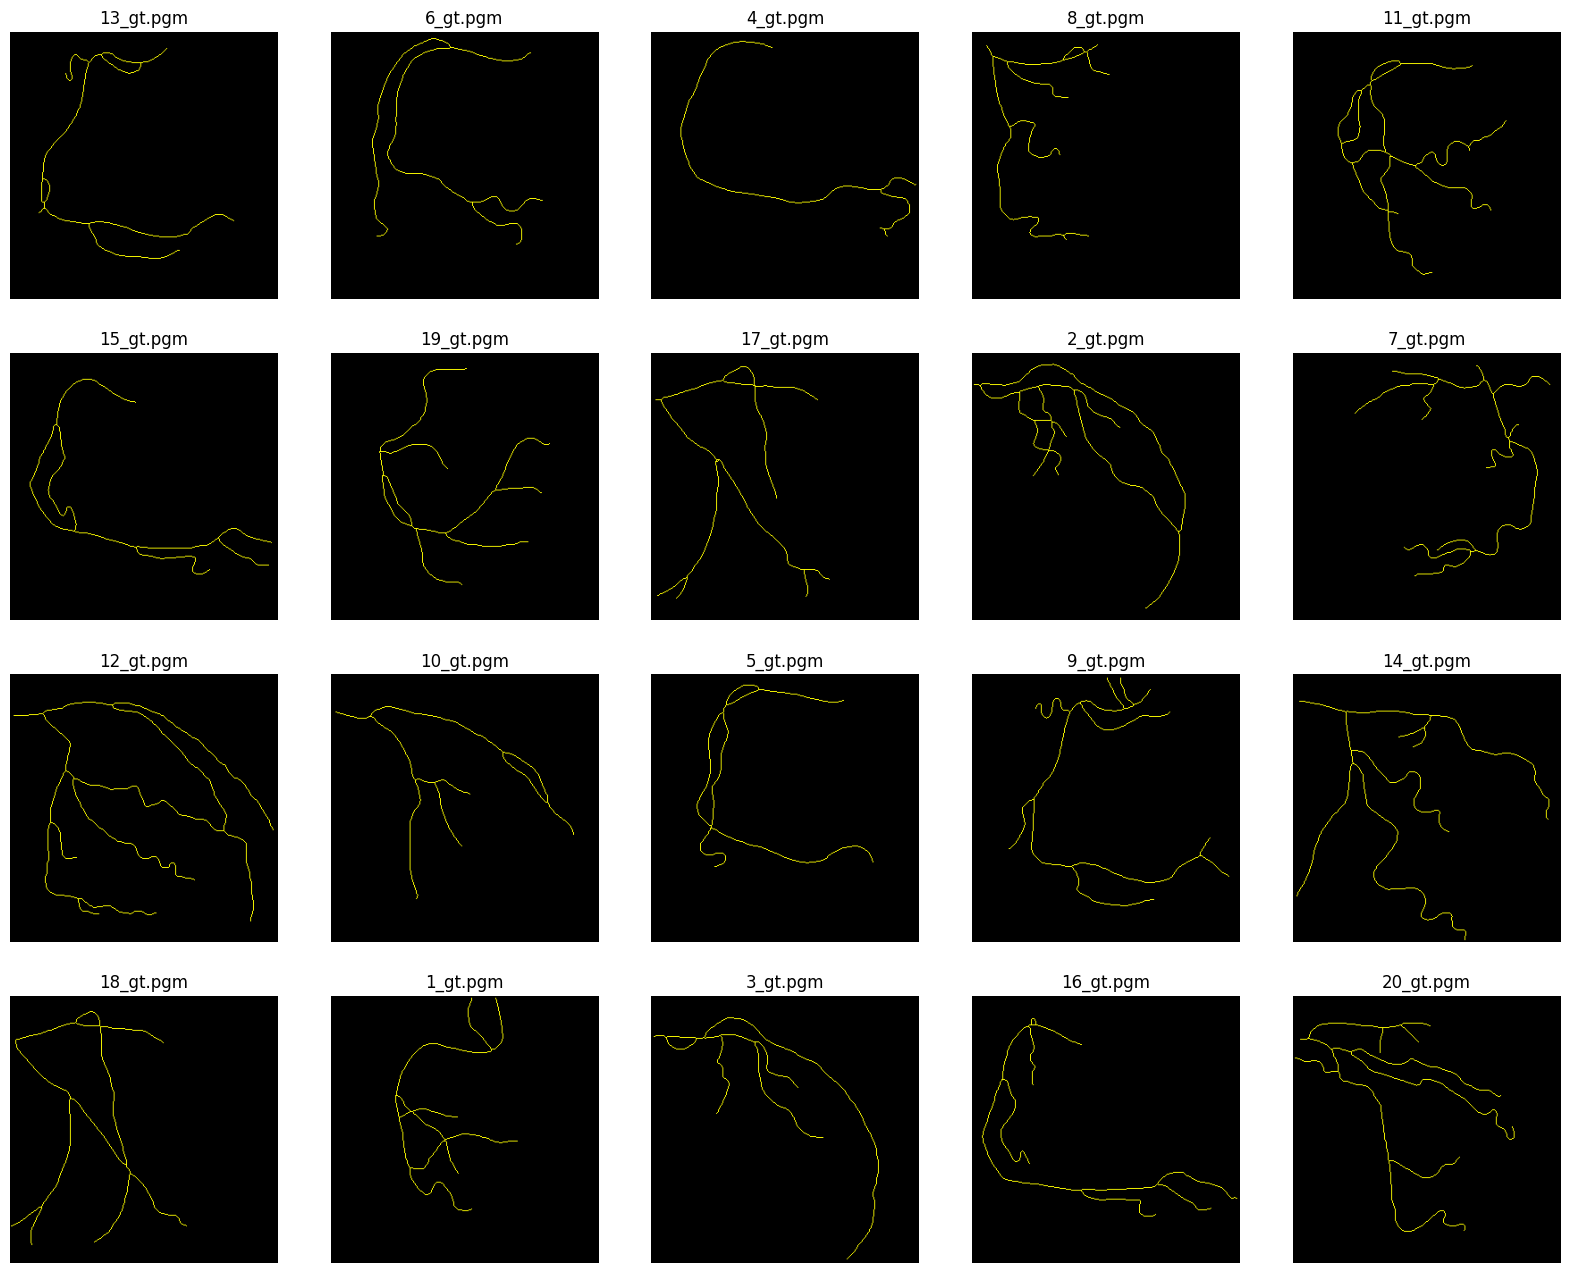

In [163]:
import numpy as np


esqueletos_color = []

for esqueleto in esqueletos:
    esqueleto_color = np.zeros((*esqueleto.shape, 3), dtype=np.uint8)
    esqueleto_color[esqueleto] = [255, 255, 0]  # Amarillo
    esqueletos_color.append(esqueleto_color)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))
for ax, esqueleto_color, nombre in zip(axes.flat, esqueletos_color, archivos):
    ax.imshow(esqueleto_color)
    ax.set_title(nombre)
    ax.axis('off')

In [164]:
def contar_vecinos(esqueleto):
    """Devuelve un arreglo con el conteo de vecinos para cada píxel."""
    from scipy.signal import convolve2d
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])
    return convolve2d(esqueleto, kernel, mode='same', boundary='fill', fillvalue=0)

def clasificar_nodos(esqueletos):
    """Clasifica los nodos de los esqueletos dados."""
    nodos_extremos, nodos_bifurcacion, nodos_trifurcacion, nodos_intermedios = [], [], [], []

    for esqueleto in esqueletos:
        vecinos = contar_vecinos(esqueleto)
        
        # Identificar nodos por tipo
        extremos = np.where(vecinos == 1)
        bifurcacion = np.where(vecinos == 3)
        trifurcacion = np.where(vecinos >= 4)

        # Identificar nodos intermedios
        intermedios = np.where((esqueleto == 1) & (vecinos != 1) & (vecinos != 2) & (vecinos != 3))
        
        nodos_extremos.append(list(zip(extremos[0], extremos[1])))
        nodos_bifurcacion.append(list(zip(bifurcacion[0], bifurcacion[1])))
        nodos_trifurcacion.append(list(zip(trifurcacion[0], trifurcacion[1])))
        nodos_intermedios.append(list(zip(intermedios[0], intermedios[1])))

    return nodos_extremos, nodos_bifurcacion, nodos_trifurcacion, nodos_intermedios


In [165]:
def check_neighbors(x, y, esqueleto):
    """
    Encuentra los vecinos de un píxel dado en el esqueleto.

    Args:
        x (int): Coordenada x del píxel.
        y (int): Coordenada y del píxel.
        esqueleto (numpy.ndarray): Esqueleto de la imagen.

    Returns:
        list: Lista de vecinos válidos.
    """
    neighbors = []

    # Verificar la existencia de vecinos en todas las direcciones posibles
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            # No considerar el píxel actual
            if dx == 0 and dy == 0:
                continue
            
            # Coordenadas del vecino
            nx, ny = x + dx, y + dy
            
            # Verificar si el vecino está dentro de los límites de la imagen
            if 0 <= nx < esqueleto.shape[0] and 0 <= ny < esqueleto.shape[1]:
                # Verificar si el vecino es un píxel del esqueleto
                if esqueleto[nx, ny] == 1:
                    neighbors.append((nx, ny))
    
    return neighbors

def find_intermediate_nodes(esqueleto, extremos, bifurcaciones, trifurcaciones):
    """Encuentra nodos intermedios en un esqueleto."""
    intermedios = []

    # Iterar sobre los píxeles del esqueleto
    for x in range(1, esqueleto.shape[0] - 1):
        for y in range(1, esqueleto.shape[1] - 1):
            # Verificar si el píxel actual es un nodo intermedio
            if esqueleto[x, y]:
                vecinos = esqueleto[x-1:x+2, y-1:y+2].sum() - 1  # Excluir el píxel central
                # Si tiene exactamente 2 vecinos y no es un nodo extremo, de bifurcación ni de trifurcación
                if vecinos == 2 and (x, y) not in extremos and (x, y) not in bifurcaciones and (x, y) not in trifurcaciones:
                    intermedios.append((x, y))
    
    # Ordenar los nodos intermedios por su posición en x o en y
    intermedios.sort(key=lambda node: node[0])  # Ordenar por coordenada x
    
    # Seleccionar solo cada n-ésimo nodo intermedio
    mod = 30  # Cambia esto según cuántos nodos intermedios quieras mostrar
    intermedios = intermedios[::mod]

    return intermedios




def find_nodes(esqueleto):
    """Encuentra nodos extremos, de bifurcación, trifurcación e intermedios en un esqueleto."""
    extremos = []
    bifurcaciones = []
    trifurcaciones = []
    nodos = []

    # Encontrar nodos extremos, de bifurcación y trifurcación
    for x in range(1, esqueleto.shape[0] - 1):
        for y in range(1, esqueleto.shape[1] - 1):
            if esqueleto[x, y]:
                vecinos = esqueleto[x-1:x+2, y-1:y+2].sum() - 1  # Excluir el píxel central
                if vecinos == 1:
                    extremos.append((x, y))
                    nodos.append((x, y, 'extremo'))
                elif vecinos == 3:
                    bifurcaciones.append((x, y))
                    nodos.append((x, y, 'bifurcacion'))
                elif vecinos == 4:
                    trifurcaciones.append((x, y))
                    nodos.append((x, y, 'trifurcacion'))

    # Encontrar nodos intermedios
    intermedios = find_intermediate_nodes(esqueleto, extremos, bifurcaciones, trifurcaciones)
    for nodo in intermedios:
        nodos.append((nodo[0], nodo[1], 'intermedio'))
    
    # Eliminar solapamientos
    nodos_no_solapados = []
    for nodo in nodos:
        x, y, tipo = nodo
        overlapping = False
        for otro_nodo in nodos_no_solapados:
            otro_x, otro_y, otro_tipo = otro_nodo
            if (x == otro_x and y == otro_y) or (abs(x - otro_x) <= 1 and abs(y - otro_y) <= 1):
                if tipo == 'extremo' and otro_tipo != 'extremo':
                    nodos_no_solapados.remove(otro_nodo)
                    nodos_no_solapados.append(nodo)
                elif tipo == 'bifurcacion' and (otro_tipo == 'trifurcacion' or otro_tipo == 'intermedio'):
                    nodos_no_solapados.remove(otro_nodo)
                    nodos_no_solapados.append(nodo)
                elif tipo == 'trifurcacion' and otro_tipo == 'intermedio':
                    nodos_no_solapados.remove(otro_nodo)
                    nodos_no_solapados.append(nodo)
                overlapping = True
                break
        if not overlapping:
            nodos_no_solapados.append(nodo)

    extremos, bifurcaciones, trifurcaciones, intermedios = [], [], [], []
    for nodo in nodos_no_solapados:
        x, y, tipo = nodo
        if tipo == 'extremo':
            extremos.append((x, y))
        elif tipo == 'bifurcacion':
            bifurcaciones.append((x, y))
        elif tipo == 'trifurcacion':
            trifurcaciones.append((x, y))
        elif tipo == 'intermedio':
            intermedios.append((x, y))

    return extremos, bifurcaciones, trifurcaciones, intermedios




In [166]:
import json

def generar_archivo_json(extremos, bifurcaciones, trifurcaciones, intermedios, archivo_destino):
    estructura_grafo = {
        "nodos": {
            "extremos": extremos,
            "bifurcaciones": bifurcaciones,
            "trifurcaciones": trifurcaciones,
            "intermedios": intermedios
        }
    }
    
    with open(archivo_destino, 'w') as file:
        json.dump(estructura_grafo, file, indent=4)

Imagen guardada en: ./database_problema2/13_esqueleto.png
Archivo JSON generado: ./database_problema2/13_grafo.json


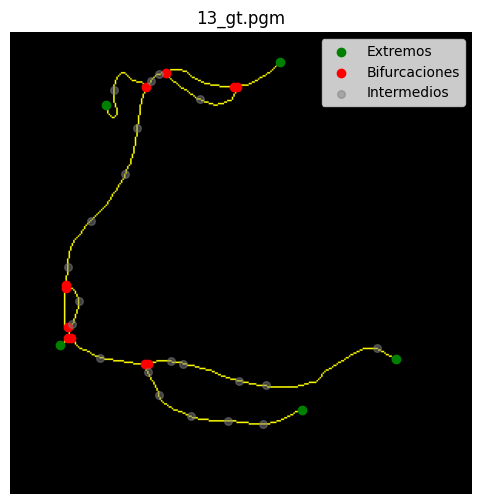

Imagen guardada en: ./database_problema2/6_esqueleto.png
Archivo JSON generado: ./database_problema2/6_grafo.json


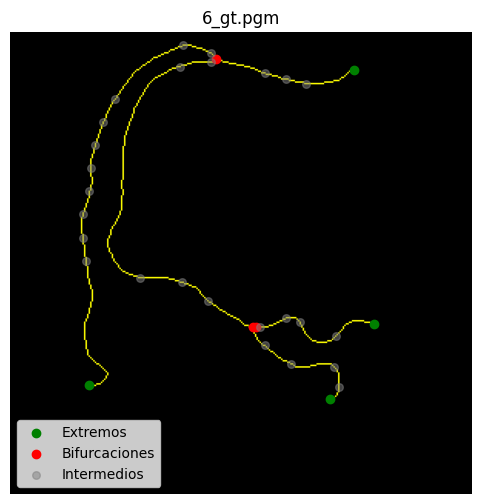

Imagen guardada en: ./database_problema2/4_esqueleto.png
Archivo JSON generado: ./database_problema2/4_grafo.json


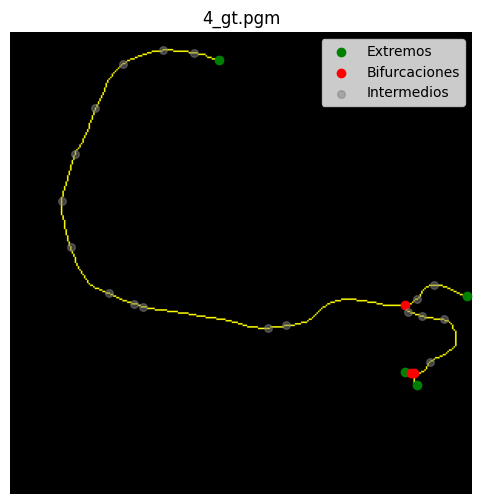

Imagen guardada en: ./database_problema2/8_esqueleto.png
Archivo JSON generado: ./database_problema2/8_grafo.json


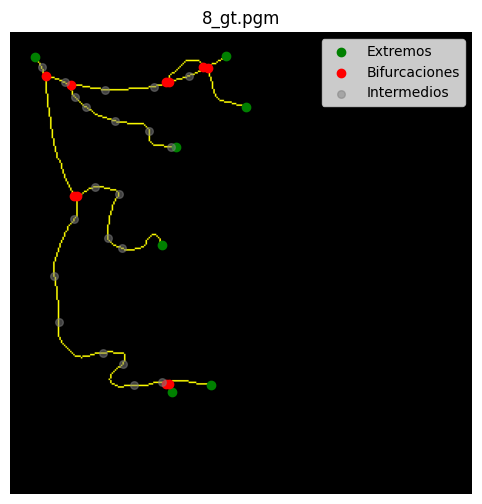

Imagen guardada en: ./database_problema2/11_esqueleto.png
Archivo JSON generado: ./database_problema2/11_grafo.json


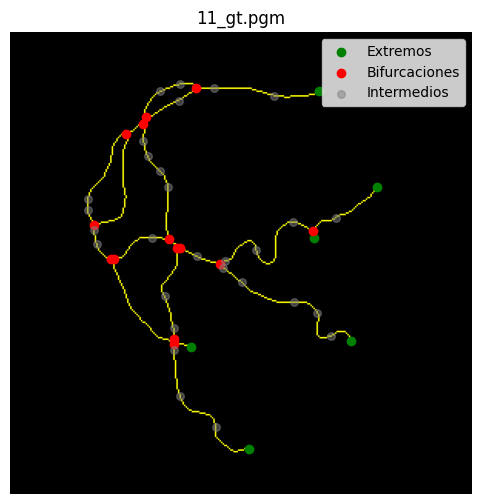

Imagen guardada en: ./database_problema2/15_esqueleto.png
Archivo JSON generado: ./database_problema2/15_grafo.json


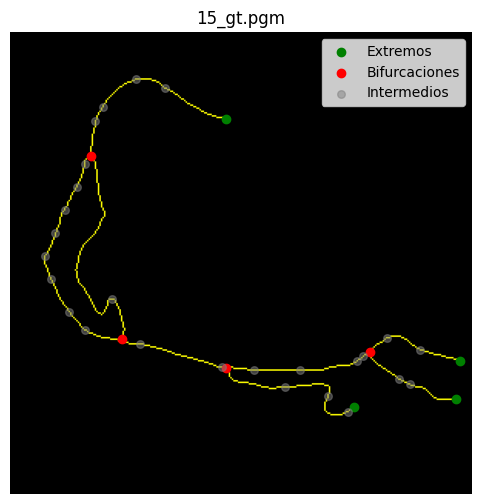

Imagen guardada en: ./database_problema2/19_esqueleto.png
Archivo JSON generado: ./database_problema2/19_grafo.json


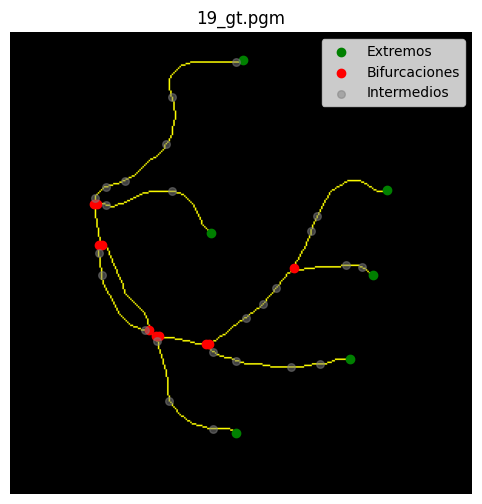

Imagen guardada en: ./database_problema2/17_esqueleto.png
Archivo JSON generado: ./database_problema2/17_grafo.json


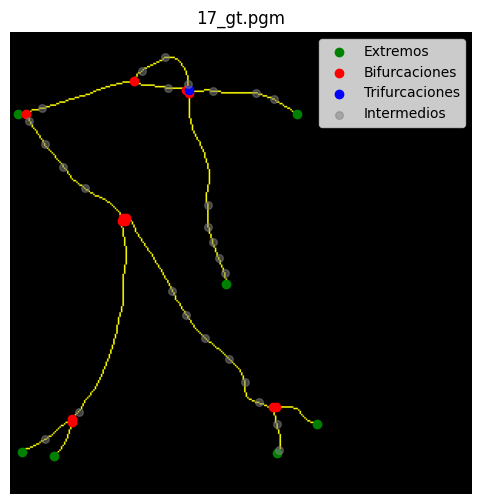

Imagen guardada en: ./database_problema2/2_esqueleto.png
Archivo JSON generado: ./database_problema2/2_grafo.json


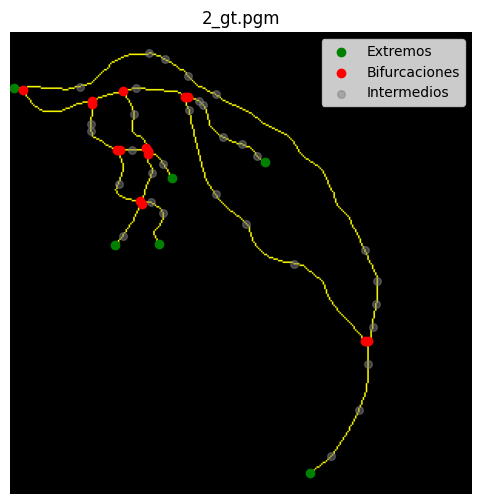

Imagen guardada en: ./database_problema2/7_esqueleto.png
Archivo JSON generado: ./database_problema2/7_grafo.json


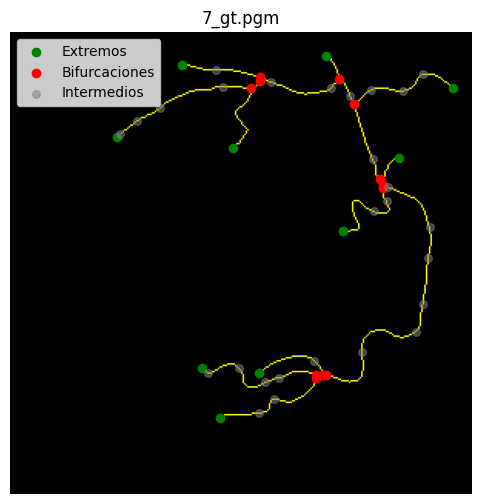

Imagen guardada en: ./database_problema2/12_esqueleto.png
Archivo JSON generado: ./database_problema2/12_grafo.json


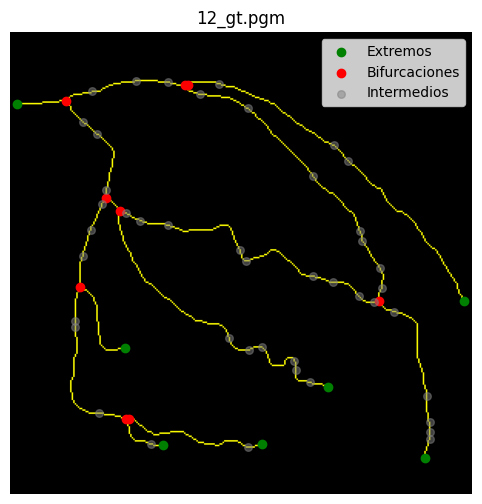

Imagen guardada en: ./database_problema2/10_esqueleto.png
Archivo JSON generado: ./database_problema2/10_grafo.json


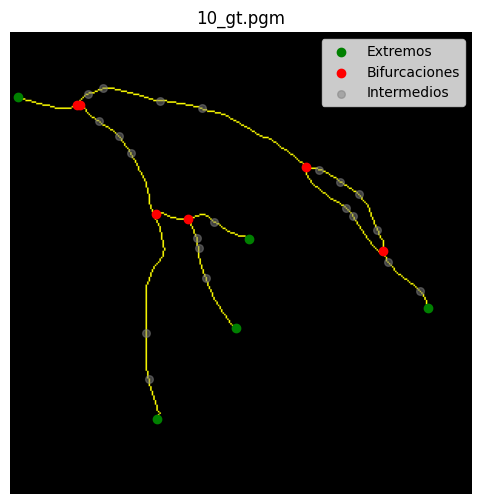

Imagen guardada en: ./database_problema2/5_esqueleto.png
Archivo JSON generado: ./database_problema2/5_grafo.json


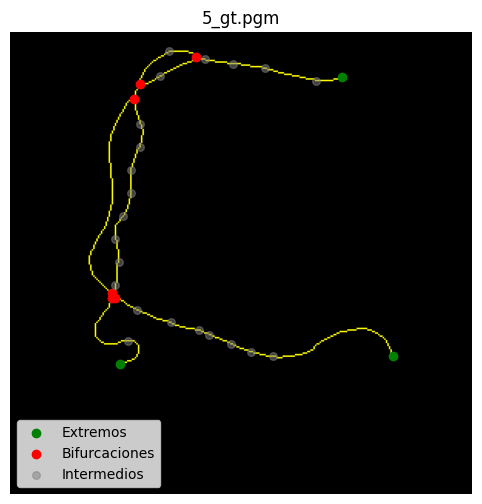

Imagen guardada en: ./database_problema2/9_esqueleto.png
Archivo JSON generado: ./database_problema2/9_grafo.json


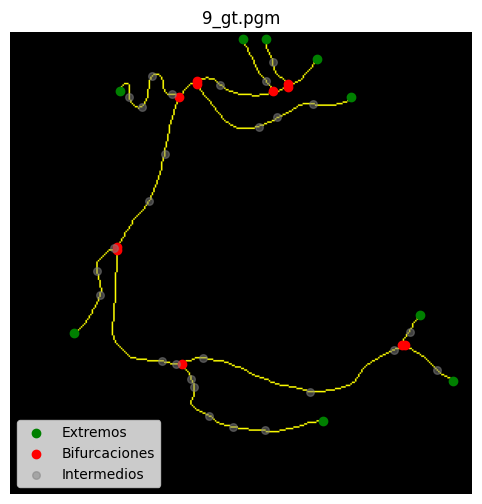

Imagen guardada en: ./database_problema2/14_esqueleto.png
Archivo JSON generado: ./database_problema2/14_grafo.json


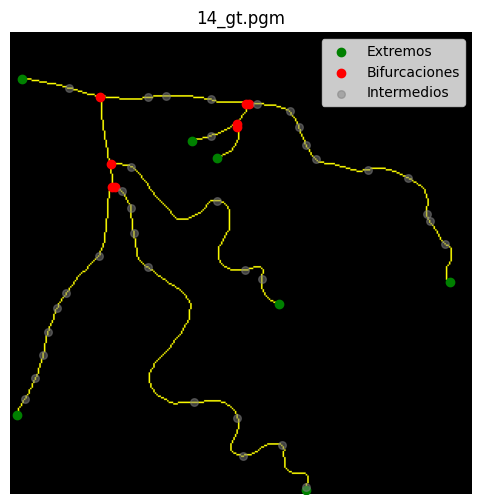

Imagen guardada en: ./database_problema2/18_esqueleto.png
Archivo JSON generado: ./database_problema2/18_grafo.json


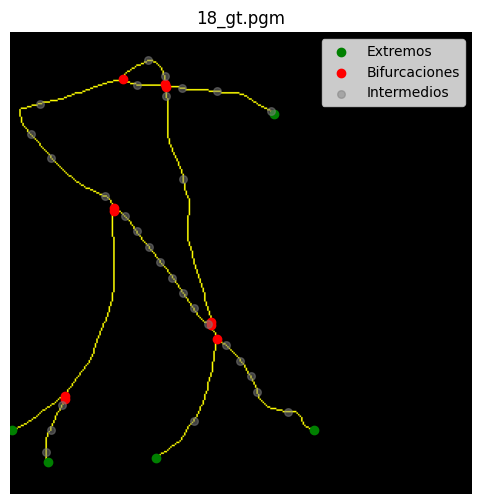

Imagen guardada en: ./database_problema2/1_esqueleto.png
Archivo JSON generado: ./database_problema2/1_grafo.json


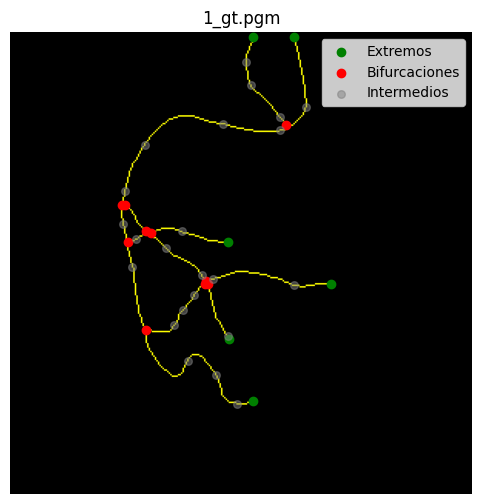

Imagen guardada en: ./database_problema2/3_esqueleto.png
Archivo JSON generado: ./database_problema2/3_grafo.json


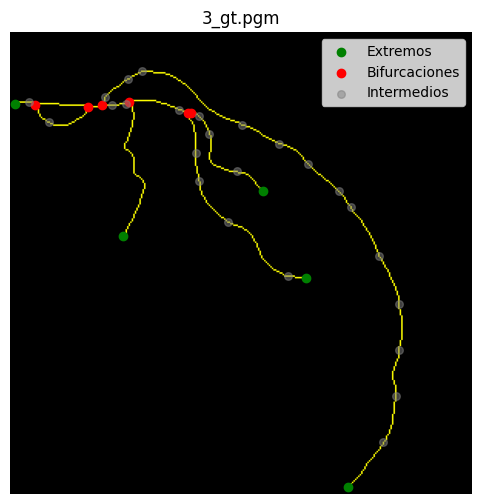

Imagen guardada en: ./database_problema2/16_esqueleto.png
Archivo JSON generado: ./database_problema2/16_grafo.json


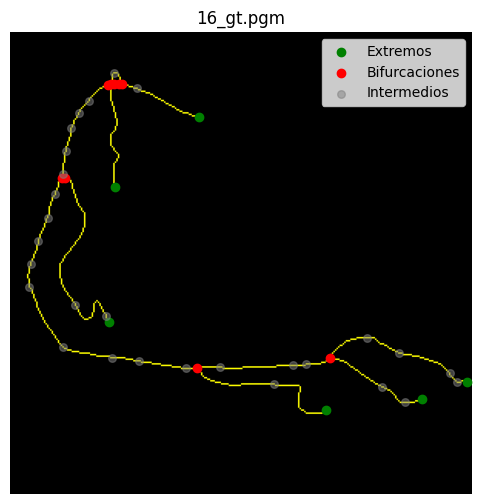

Imagen guardada en: ./database_problema2/20_esqueleto.png
Archivo JSON generado: ./database_problema2/20_grafo.json


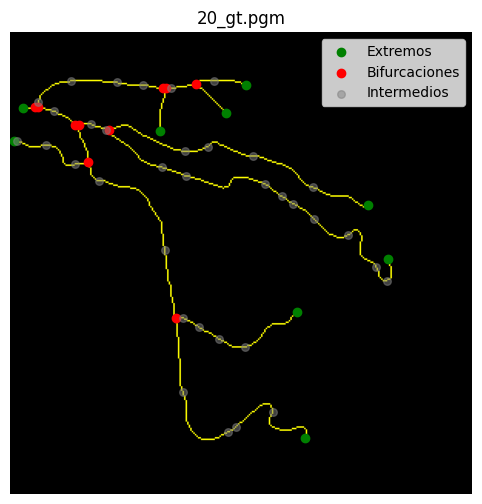

In [169]:
import os
import json
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Crear la carpeta de destino si no existe
carpeta_destino = './database_problema2'  # Carpeta destino para los archivos
if not os.path.exists(carpeta_destino):
    os.makedirs(carpeta_destino)

# Iterar sobre los esqueletos y guardar los resultados
for archivo, esqueleto_color, nombre, ext, bif, trif, inter in zip(archivos, esqueletos_color, archivos, nodos_extremos, nodos_bifurcacion, nodos_trifurcacion, nodos_intermedios):
    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Mostrar el esqueleto
    ax.imshow(esqueleto_color)
    
    # Mostrar nodos extremos en verde
    if ext:
        x_extremos = [coord[1] for coord in ext]
        y_extremos = [coord[0] for coord in ext]
        ax.scatter(x_extremos, y_extremos, color='g', label='Extremos')
    
    # Mostrar nodos de bifurcación en rojo
    if bif:
        x_bifurcaciones = [coord[1] for coord in bif]
        y_bifurcaciones = [coord[0] for coord in bif]
        ax.scatter(x_bifurcaciones, y_bifurcaciones, color='r', label='Bifurcaciones')
    
    # Mostrar nodos de trifurcación en azul
    if trif:
        x_trifurcaciones = [coord[1] for coord in trif]
        y_trifurcaciones = [coord[0] for coord in trif]
        ax.scatter(x_trifurcaciones, y_trifurcaciones, color='b', label='Trifurcaciones')
    
    # Mostrar nodos intermedios en gris
    if inter:
        x_intermedios = [coord[1] for coord in inter]
        y_intermedios = [coord[0] for coord in inter]
        ax.scatter(x_intermedios, y_intermedios, color='gray', alpha=0.5, label='Intermedios', s=30)  # Ajustar el tamaño aquí
    
    # Título y leyenda
    ax.set_title(nombre)
    ax.axis('off')
    ax.legend()

    # Guardar la figura en un archivo
    archivo_imagen_destino = os.path.join(carpeta_destino, archivo.replace('_gt.pgm', '_esqueleto.png'))
    plt.savefig(archivo_imagen_destino, bbox_inches='tight')  # bbox_inches='tight' asegura que no se recorten los bordes
    plt.close()  # Cerrar la figura para liberar memoria

    print(f'Imagen guardada en: {archivo_imagen_destino}')
    
    # Generar y guardar archivo JSON
    archivo_json_destino = os.path.join(carpeta_destino, archivo.replace('_gt.pgm', '_grafo.json'))
    generar_archivo_json(ext, bif, trif, inter, archivo_json_destino)
    
    print(f'Archivo JSON generado: {archivo_json_destino}')
    
    # Mostrar la imagen en el notebook
    display(Image(filename=archivo_imagen_destino))
